## Librerías

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Librerías
import numpy as np
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import keras
from sklearn.model_selection import train_test_split
import os


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import umap
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

2023-10-09 20:29:56.790510: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-09 20:29:56.838103: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mo

2.12.0


In [5]:
## Uso de GPU
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

## Datos

In [6]:
## Obtener todas las rutas de las imágenes en el dataset
rutas_dataset  = glob.glob('/home/willy98/archivos/Datasets/Micrografías_segmentadas/secas/*/*/*/*.jpg')

## Separar rutas
mask_list = []
image_list = []
for ruta in rutas_dataset:
    ruta_list = ruta.split('/')
    clase = ruta_list[7]
    number = ruta_list[8]
    tipo = ruta_list[9]
    name = ruta_list[10].split('.')[0]
    
    if tipo == 'train':
        image_list.append([name,ruta,clase,number])
    elif tipo == 'mask_bin':
        mask_list.append([name,ruta,clase,number])
    else:
        None

mask_pd = pd.DataFrame(mask_list,columns=['name','route_mask','class','number']).sort_values(by='name')
image_pd = pd.DataFrame(image_list,columns=['name','route_image','class','number']).sort_values(by='name')

routes_dataset = image_pd.merge(mask_pd,on=['name','class','number'],how='left')

routes_dataset.dropna(inplace=True)

routes_dataset = routes_dataset.sample(frac = 1)

print('Imágenes secas:', np.shape(routes_dataset)[0])
print('MF1:', '- secas: ', np.shape(routes_dataset[routes_dataset['class']=='MF1'])[0])
print('MF2:', '- secas: ', np.shape(routes_dataset[routes_dataset['class']=='MF2'])[0])
print('MF3:', '- secas: ', np.shape(routes_dataset[routes_dataset['class']=='MF3'])[0])

char_to_num = {'MF1':'0','MF2':'1','MF3':'2'}

routes_dataset['class'].replace(char_to_num,inplace=True)

routes_dataset

Imágenes secas: 927
MF1: - secas:  378
MF2: - secas:  288
MF3: - secas:  261


,name,route_image,class,number,route_mask
435,IMG_20230707_191356_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,7,/home/willy98/archivos/Datasets/Micrografías_s...
126,IMG_20230707_162136_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,1,/home/willy98/archivos/Datasets/Micrografías_s...
770,IMG_20230711_210725_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,2,/home/willy98/archivos/Datasets/Micrografías_s...
574,IMG_20230711_163337_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,1,3,/home/willy98/archivos/Datasets/Micrografías_s...
546,IMG_20230711_161130_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,1,2,/home/willy98/archivos/Datasets/Micrografías_s...
...,...,...,...,...,...
24,IMG_20230601_152346_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,1,/home/willy98/archivos/Datasets/Micrografías_s...
647,IMG_20230711_174349_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,1,5,/home/willy98/archivos/Datasets/Micrografías_s...
566,IMG_20230711_163229_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,1,3,/home/willy98/archivos/Datasets/Micrografías_s...
817,IMG_20230711_212316_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,7,/home/willy98/archivos/Datasets/Micrografías_s...


In [7]:
## Establecer el porcentaje de separación
prct_train = 0.8

thold1 = int(np.ceil(prct_train * len(routes_dataset[routes_dataset['class']=='0'])))
thold2 = int(np.ceil(prct_train * len(routes_dataset[routes_dataset['class']=='1'])))
thold3 = int(np.ceil(prct_train * len(routes_dataset[routes_dataset['class']=='2'])))

## Separar por clases para entrenamiento
train_cu1 = routes_dataset[routes_dataset['class'] == '0'][0:thold1]
train_cu2 = routes_dataset[routes_dataset['class'] == '1'][0:thold2]
train_cu3 = routes_dataset[routes_dataset['class'] == '2'][0:thold3]

## tomar las demás imágenes para test
test_cu1 = routes_dataset[routes_dataset['class'] == '0'][thold1:]
test_cu2 = routes_dataset[routes_dataset['class'] == '1'][thold2:]
test_cu3 = routes_dataset[routes_dataset['class'] == '2'][thold3:]

## Cantidad de muestras por clase
print('Clase MF1: train: ',len(train_cu1),', test: ',len(test_cu1))
print('Clase MF2: train: ',len(train_cu2),', test: ',len(test_cu2))
print('Clase MF3: train: ',len(train_cu3),', test: ',len(test_cu3))

Clase MF1: train:  303 , test:  75
Clase MF2: train:  231 , test:  57
Clase MF3: train:  209 , test:  52


In [8]:
### Definir datasets de training y test
# Todas las clases
train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3])
test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3])

# solo una clase
#train_df = train_cu1
#test_df = test_cu1

train_df

,name,route_image,class,number,route_mask
435,IMG_20230707_191356_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,7,/home/willy98/archivos/Datasets/Micrografías_s...
126,IMG_20230707_162136_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,1,/home/willy98/archivos/Datasets/Micrografías_s...
469,IMG_20230707_191903_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,7,/home/willy98/archivos/Datasets/Micrografías_s...
436,IMG_20230707_191401_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,7,/home/willy98/archivos/Datasets/Micrografías_s...
413,IMG_20230707_185215_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,6,/home/willy98/archivos/Datasets/Micrografías_s...
...,...,...,...,...,...
793,IMG_20230711_211507_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,2,/home/willy98/archivos/Datasets/Micrografías_s...
86,IMG_20230602_221704_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,4,/home/willy98/archivos/Datasets/Micrografías_s...
855,IMG_20230711_214558_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,6,/home/willy98/archivos/Datasets/Micrografías_s...
34,IMG_20230602_210357_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,3,/home/willy98/archivos/Datasets/Micrografías_s...


In [9]:
## Crear objetos transformadores
## Para entrenamiento
SEED = 100

img_generator_images = tf.keras.preprocessing.image.ImageDataGenerator(  
    rescale=1./255,      
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

img_generator_mask = tf.keras.preprocessing.image.ImageDataGenerator(  
    rescale=1./255,      
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

## Crear objeto generador de imágenes a partir del objeto transformator
## Pra entrenamiento
train_generator_IMAGES = img_generator_images.flow_from_dataframe(
    dataframe=train_df,
    #directory="./train/",
    x_col="route_image",
    y_col="class",
    labels = ['MF1'],
    #labels = ['MF2'],
    subset="training",
    batch_size=64,
    seed=SEED,
    shuffle=True,
    class_mode="sparse" ,
    validation_split=0.2,
    color_mode ="grayscale",
    target_size=(128,128))

train_generator_MASK = img_generator_mask.flow_from_dataframe(
    dataframe=train_df,
    #directory="./train/",
    x_col="route_mask",
    y_col="class",
    labels = ['MF1'],
    #labels = ['MF2'],
    subset="training",
    batch_size=64,
    seed=SEED,
    shuffle=True,
    class_mode="sparse" ,
    validation_split=0.2,
    color_mode ="grayscale",
    target_size=(128,128))

Found 595 validated image filenames belonging to 3 classes.
Found 595 validated image filenames belonging to 3 classes.


In [10]:
X_train_images = []
train_mask = []
label_train_images  = []
label_train_mask = []

batches = 50
cnt = 0

for i in range(batches):
    
    x,y = train_generator_IMAGES.next()

    X_train_images.extend(x)
    label_train_images.extend(y)
    
for i in range(batches):
    
    x,y = train_generator_MASK.next()

    train_mask.extend(x)
    label_train_mask.extend(y)
    
    
print(np.shape(train_mask),np.shape(train_mask))
print(np.array_equal(label_train_mask,label_train_images))

(2975, 128, 128, 1) (2975, 128, 128, 1)
True


1.0 1.0


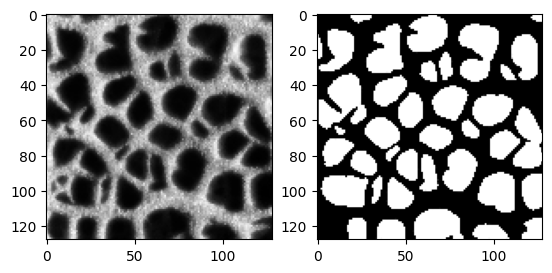

In [11]:
## Visualizar:
n = 0
fig, (ax1, ax2) = plt.subplots(1, 2)
ax2.imshow(train_mask[n],cmap='gray')
ax1.imshow(X_train_images[n],cmap='gray')
print(label_train_mask[n],label_train_images[n])
plt.show()

In [12]:
## Dataset de prueba
test_df_shuffled = test_df.sample(frac=1,random_state=42).reset_index(drop=True)

X_test_images = []
y_test_images = []
X_test_mask = []
y_test_mask = []

nsize = 128

## Recorrerr rutas
for i in range(len(test_df_shuffled)):
    
    #Capturar ruta y label
    ruta_img = test_df_shuffled.iloc[i].route_image
    label_img = test_df_shuffled.iloc[i]['class']
    ruta_mask = test_df_shuffled.iloc[i].route_mask
    label_mask = test_df_shuffled.iloc[i]['class']
    
    ##cargar imagen
    im = tf.keras.preprocessing.image.load_img(ruta_img,color_mode='grayscale')
    msk = tf.keras.preprocessing.image.load_img(ruta_mask,color_mode='grayscale')
    
    X_test_images.append(tf.keras.preprocessing.image.img_to_array(im.resize((nsize,nsize))))
    y_test_images.append(label_img)
    
    X_test_mask.append(tf.keras.preprocessing.image.img_to_array(msk.resize((nsize,nsize))))
    y_test_mask.append(label_mask)
    
print('Test: images->',np.shape(X_test_images),' label ->',np.shape(y_test_images))
print('Test: mask->',np.shape(X_test_mask),' label ->',np.shape(y_test_mask))

Test: images-> (184, 128, 128, 1)  label -> (184,)
Test: mask-> (184, 128, 128, 1)  label -> (184,)


In [13]:
x_train_images = np.array(X_train_images)
x_test_images = np.array(X_test_images)

x_train_images = x_train_images.astype('float32')
x_test_images= x_test_images.astype('float32')
 
#y_test_images = tf.keras.utils.to_categorical(y_test_images)
#y_train_expanded = tf.keras.utils.to_categorical(y_train_expanded) 

#x_train_expanded /= 255
x_test_images /= 255

print('x_train shape:', x_train_images.shape)
print('Number of images in x_train', x_train_images.shape, "y_train:", np.shape(label_train_images))
print('Number of images in x_test', x_test_images.shape, "y_test: ", np.shape(y_test_images))

x_train shape: (2975, 128, 128, 1)
Number of images in x_train (2975, 128, 128, 1) y_train: (2975,)
Number of images in x_test (184, 128, 128, 1) y_test:  (184,)


## Modelo

In [14]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [15]:
VAE_encoder = keras.models.load_model('Models/GVAE_DRY_128_1_encoder.h5', custom_objects={'Sampling':Sampling},compile=False)
VAE_decoder = keras.models.load_model('Models/GVAE_DRY_128_1_decoder.h5', custom_objects={'Sampling':Sampling},compile=False)

2023-10-09 20:35:06.872409: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4816 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:1a:00.0, compute capability: 7.5


## Grad-Cam

In [17]:
# Se carga el modelo completo
#model_base = encoder
model = VAE_encoder
model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 layer_E1 (Conv2D)              (None, 128, 128, 10  10240       ['input_1[0][0]']                
                                24)                                                               
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 1024  0           ['layer_E1[0][0]']               
                                )                                                           

In [64]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.6):
    import matplotlib
    # Load the original image
    nsize = 128
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img.resize((nsize,nsize)))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps['jet']

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    #superimposed_img.save(cam_path)
    
    # Display Grad CAM
    #display(Image(cam_path))
    
    return superimposed_img, jet_heatmap * alpha

In [65]:
## Paso a paso del código:

## Parámetros
clases = ['CuNi1','CuNi2','CuNi3']
last_conv_layer_name = 'layer_E7'
nsize = 128
dim = 128

## crear modelo grad_cam
grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

## Diccionario de clases
clase = {'CuNi1':0,'CuNi2':1,'CuNi3':2}

## Indices para seleccionar imágenes de forma aleatoria
## train
indx_train_mf1 = np.random.randint(low=0,high=len(train_cu1),size = 2)
indx_train_mf2 = np.random.randint(low=0,high=len(train_cu2),size = 2)
indx_train_mf3 = np.random.randint(low=0,high=len(train_cu3),size = 2)
## Test
indx_test_mf1 = np.random.randint(low=0,high=len(test_cu1),size = 2)
indx_test_mf2 = np.random.randint(low=0,high=len(test_cu2),size = 2)
indx_test_mf3 = np.random.randint(low=0,high=len(test_cu3),size = 2)

In [66]:
train_cu1

,name,route_image,class,number,route_mask
435,IMG_20230707_191356_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,7,/home/willy98/archivos/Datasets/Micrografías_s...
126,IMG_20230707_162136_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,1,/home/willy98/archivos/Datasets/Micrografías_s...
469,IMG_20230707_191903_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,7,/home/willy98/archivos/Datasets/Micrografías_s...
436,IMG_20230707_191401_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,7,/home/willy98/archivos/Datasets/Micrografías_s...
413,IMG_20230707_185215_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,6,/home/willy98/archivos/Datasets/Micrografías_s...
...,...,...,...,...,...
321,IMG_20230707_180427_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,5,/home/willy98/archivos/Datasets/Micrografías_s...
259,IMG_20230707_173513_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,4,/home/willy98/archivos/Datasets/Micrografías_s...
318,IMG_20230707_180420_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,5,/home/willy98/archivos/Datasets/Micrografías_s...
384,IMG_20230707_184724_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,6,/home/willy98/archivos/Datasets/Micrografías_s...


In [68]:
## Grad-CAM para una imágen
indx = 0
data = train_cu1

## Ruta de la imágen original
img_route = data.reset_index(drop=True).loc[0].route_image

## leer imagen
img0 = tf.keras.preprocessing.image.load_img(img_route,color_mode='grayscale') 

# Array y redimensionar
img0 = tf.keras.preprocessing.image.img_to_array(img0.resize((nsize,nsize)))

# expand dims para que el modelo lo pueda leer
img = np.expand_dims(img0, axis=0)

## Lista para guardar los mapas de explicabilidad
gap_maps = []
merge_imgs = []

## Recorrer las N dimensiones del embebido
for pred_index in range(128):
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img)    
        ## Selecciono el indice a representar como CAM
        class_channel = preds[2][0][pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)


    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    pooled_grads

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)   
    #heatmap = tf.nn.relu(heatmap)    

    merged, fit_heatmap = save_and_display_gradcam(img_route, heatmap)

    gap_maps.append(fit_heatmap)
    merge_imgs.append(merged)   

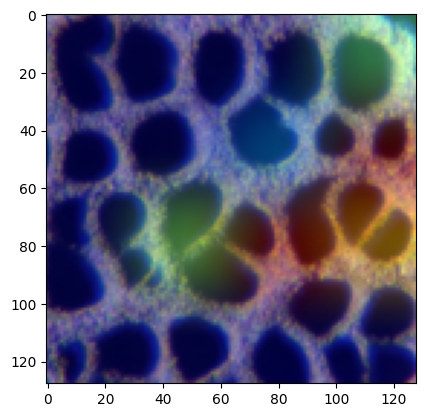

In [69]:
plt.imshow(merge_imgs[0],cmap='jet')